In [1]:
import torch
import monai
from glob import glob
from monai.transforms import Compose
from pathlib import Path
import torchio as tio
import os
from tqdm import tqdm
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
import monai.networks
import monai.networks.nets
from dataset import MedicalDataset
from model import get_model
from sklearn.decomposition import PCA

/home/johannes/anaconda3/envs/medicaldino/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 243/243 [02:09<00:00,  1.88it/s]


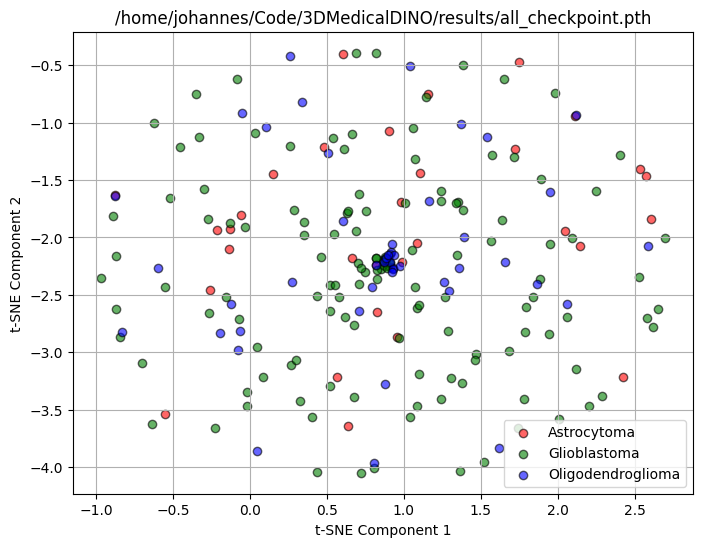

100%|██████████| 243/243 [01:07<00:00,  3.58it/s]


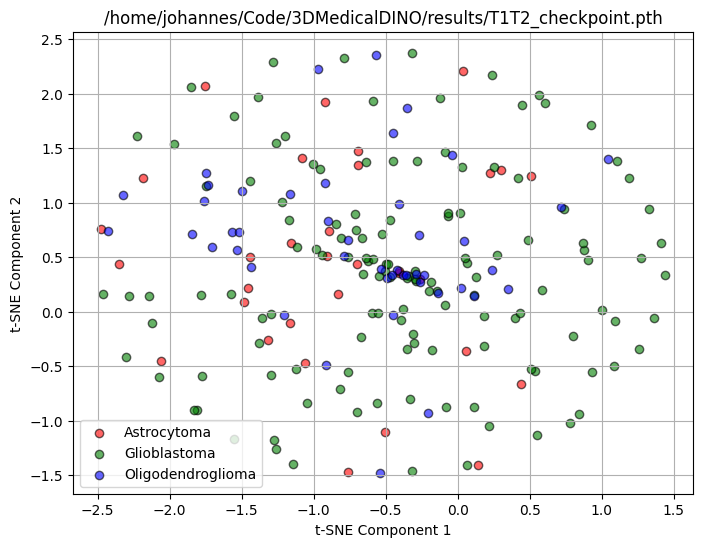

In [2]:
sequence = "all"

for sequence in ["all", "T1T2"]:

    model = "ResNext50"

    # TCGA - All
    volumes_list = []
    segmentations_list = []
    volumes_list.extend(sorted(glob("/home/johannes/Code/3DMedicalDINO/data/tcga/*/preop/*space-sri_t1c.nii.gz")))
    segmentations_list.extend(sorted(glob("/home/johannes/Code/3DMedicalDINO/data/tcga/*/preop/*space-sri_seg.nii.gz")))

    dataset = MedicalDataset(args=None, sequence=sequence, transform=False, volumes=volumes_list, segmentations=segmentations_list)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1) 

    for checkpoint_path in glob(f"/home/johannes/Code/3DMedicalDINO/results/{sequence}_checkpoint.pth")[:1]:
        _, model, _ = get_model(model_name=model, sequence=sequence)
        model.load_state_dict(torch.load(checkpoint_path, weights_only=False)["teacher"], strict=False)

        features = []
        labels = []
        dims = []
        df = pd.read_csv("/home/johannes/Code/3DMedicalDINO/data/tcga/histology.csv")

        for volume, filepath in tqdm(dataloader):
            
            try:
                # img = volumes_list[i]
                # seg = segmentations_list[i]
                patient_id = filepath[0].split("/")[-3]
                label = df[df["case_submitter_id"] == patient_id]["primary_diagnosis"].item()

                if label not in ['Astrocytoma, NOS', 'Astrocytoma, anaplastic', 'Glioblastoma', 'Oligodendroglioma, NOS', 'Oligodendroglioma, anaplastic']:
                    continue

                # img_crop = get_crop(img, seg)   

                out = model(volume)

                # dims.append(img_crop.shape)
                labels.append(label)
                features.append(out)
            
            except:
                continue

        features = torch.concatenate(features)
        labels = ["Astrocytoma" if "Astrocytoma" in label else "Glioblastoma" if "Glioblastoma" in label else "Oligodendroglioma" for label in labels]
        labels = np.array(labels)

        data_np = features.detach().numpy()

        tsne = TSNE(n_components=2, random_state=42, perplexity=30)
        data_2d = tsne.fit_transform(data_np)
        # pca = PCA(n_components=2, random_state=42)
        # data_2d = pca.fit_transform(data_np)
        

        plot_data = pd.DataFrame({
            'x': data_2d[:, 0],
            'y': data_2d[:, 1],
            'label': labels
        })

        # Step 6: Plot the 2D visualization with colored points based on labels
        plt.figure(figsize=(8, 6))
        colors = {'Astrocytoma': 'red', 'Glioblastoma': 'green', 'Oligodendroglioma': 'blue'}
        for label in colors:
            subset = plot_data[plot_data['label'] == label]
            plt.scatter(subset['x'], subset['y'], c=colors[label], label=label, alpha=0.6, edgecolors='k')

        plt.title(f"{checkpoint_path}")
        plt.xlabel("t-SNE Component 1")
        plt.ylabel("t-SNE Component 2")
        plt.legend()
        plt.grid(True)
        plt.show()

    